In [3]:
import pandas as pd
import numpy as np
import os
import re
from collections import defaultdict

In [132]:
log_folder = 'logs/snp_no_feature_engineering_two_transform_no_sampling/'

def agg_by_threshold(thresholds):
    files = sorted(os.listdir(log_folder))
    by_threshold = []
    for threshold in thresholds:
        by_threshold += [[file for file in files if threshold in file.split('_')[-1]]]
    return by_threshold

In [133]:
def create_key(original_line):
    result = []
    of_interest = ['block_depth', 
                   'const_factor', 
                   'learning_rate', 
                   'linear_dim', 
                   'percentile',
                  ]
    for item in of_interest:
        pattern = re.compile(item+'=[\d.]*')
        result += [re.search(pattern, original_line).group(0)]
    return ','.join(result)

In [134]:
def process_single_log_file(file_path):
    split_colon = lambda x: x.split(':')

    test_data = (pd.read_csv(file_path)
                   .iloc[:-1, 2:]
                   .iloc[1::2]
                   .iloc[:, 1:9]
                   .applymap(split_colon))
    
    if test_data.empty:
        return None
    
    names = (test_data.applymap(lambda x: x[0])
                      .iloc[0]
                      .values
                      .tolist())
    names = list(map(lambda x: x.replace(' ', ''), names))
    dataframe = (test_data.iloc[:, :-1].applymap(lambda x: float(x[-1]))
                          .copy())
    confusion_matrix_ = test_data.iloc[:, -1].map(lambda x: x[-1]).copy()
    dataframe = pd.concat((dataframe, confusion_matrix_), axis=1)
    dataframe.columns = names
    
    return dataframe

In [135]:
def get_key_and_df(file_name):
    file_path = log_folder + file_name

    with open(file_path, 'r') as f:
        line = f.readlines()[0]
        key = create_key(line)
    
    df = process_single_log_file(file_path)
    
    if df is None:
        return None, None
    else:
        return key, df 

In [136]:
def get_relevant_key_df(file_name):
    key, df = get_key_and_df(file_name)
    if df is None:
        return None, None
    
#     relevant_df = df[(df.F1Score > 0.01) & 
#                      (df.index < 60) &
#                      (df.BCE <= df.BCE.quantile(0.1))
#                     ].copy()
    return key, df

    if len(relevant_df) > 0:
        return key, relevant_df
    else:
        return None, None

In [137]:
def garner_relevant_dictionary():
    
    thresholds = ['0.1', '0.2', '0.3', '0.35', '0.65', '0.7', '0.8', '0.9']
    files_by_thresholds = agg_by_threshold(thresholds)

    # Not sure if this should be default_dict
    so_far = defaultdict(list)
    for files in files_by_thresholds:
        for file in files:
            key, df = get_relevant_key_df(file)
            if key is not None:
                so_far[key].append(df)
    
    return so_far

In [138]:
my_dict = garner_relevant_dictionary()
# iter_my_dict = iter(my_dict.items())

In [139]:
training_results = []
pct = 0.8
statement = 'percentile={}'.format(pct)
for key, df in my_dict.items():
    if statement in key : # and 'block_depth=3' in key:
        if len(df) > 1:
            print('key {} has length: {} > 1'.format(key, len(df)))
        training_results.append((key, df[0]))

In [140]:
# training_results_sorted = sorted(training_results, 
#                                  key=lambda x: (x[1].Mean*x[1].F1Score).mean(), 
#                                  reverse=True)
reverse = pct > 0.5

training_results_sorted = sorted(training_results, 
                                 key=lambda x: (x[1].Mean).mean(), 
                                 reverse=reverse)

In [141]:
for key, result in training_results_sorted:
    print(key)

block_depth=3,const_factor=2,learning_rate=0.007,linear_dim=2,percentile=0.8
block_depth=4,const_factor=6,learning_rate=0.007,linear_dim=6,percentile=0.8
block_depth=2,const_factor=2,learning_rate=0.007,linear_dim=2,percentile=0.8
block_depth=4,const_factor=6,learning_rate=0.007,linear_dim=2,percentile=0.8
block_depth=5,const_factor=2,learning_rate=0.007,linear_dim=2,percentile=0.8
block_depth=5,const_factor=6,learning_rate=0.007,linear_dim=4,percentile=0.8
block_depth=5,const_factor=2,learning_rate=0.007,linear_dim=6,percentile=0.8
block_depth=2,const_factor=2,learning_rate=0.007,linear_dim=6,percentile=0.8
block_depth=3,const_factor=2,learning_rate=0.007,linear_dim=6,percentile=0.8
block_depth=2,const_factor=6,learning_rate=0.007,linear_dim=2,percentile=0.8
block_depth=3,const_factor=4,learning_rate=0.007,linear_dim=4,percentile=0.8
block_depth=2,const_factor=4,learning_rate=0.007,linear_dim=6,percentile=0.8
block_depth=2,const_factor=6,learning_rate=0.007,linear_dim=6,percentile=0.8

In [142]:
print('F1Score, Mean, Precision, Stdev, Count')
for key, result in training_results_sorted:
    print('{:.5f}, {:.5f}, {:.5f}, {:.5f}, {}'.format(
          result.F1Score.mean(), 
          result.Mean.mean(),
          result.Precision.mean(), 
          result.Stdev.mean(),
          result.Mean.count(),)
         )

F1Score, Mean, Precision, Stdev, Count
0.05768, 0.01447, 0.38043, 0.03286, 23
0.13645, 0.01436, 0.40789, 0.03621, 27
0.16538, 0.01289, 0.32401, 0.03623, 25
0.19487, 0.01109, 0.37414, 0.03620, 30
0.10355, 0.01106, 0.34113, 0.03538, 25
0.17070, 0.01026, 0.32677, 0.03737, 26
0.07380, 0.00990, 0.26473, 0.03625, 22
0.13014, 0.00973, 0.32911, 0.03699, 25
0.16041, 0.00970, 0.33020, 0.03626, 24
0.19818, 0.00938, 0.30856, 0.03864, 26
0.20476, 0.00913, 0.28897, 0.03611, 26
0.12417, 0.00888, 0.29278, 0.03589, 24
0.15717, 0.00836, 0.29015, 0.03662, 24
0.18969, 0.00831, 0.31281, 0.03732, 26
0.21347, 0.00821, 0.29517, 0.03970, 26
0.19201, 0.00821, 0.34792, 0.03750, 30
0.12419, 0.00819, 0.26879, 0.03852, 22
0.15787, 0.00789, 0.29668, 0.03749, 25
0.22124, 0.00786, 0.29914, 0.03717, 27
0.12238, 0.00786, 0.31733, 0.03497, 28
0.26093, 0.00786, 0.28960, 0.03777, 27
0.11340, 0.00772, 0.23472, 0.03184, 23
0.20068, 0.00758, 0.31190, 0.03686, 27
0.21150, 0.00737, 0.30295, 0.03920, 29
0.19533, 0.00737, 0.25960

In [143]:
import matplotlib.pyplot as plt

In [144]:
ranks = 1
print(training_results_sorted[ranks][0])

training_results_sorted[ranks][1]
# training_results_sorted[ranks][1].BCE.plot()

block_depth=4,const_factor=6,learning_rate=0.007,linear_dim=6,percentile=0.8


,BCE,F1Score,ROC_AUC,Precision,Recall,Mean,Stdev,ConfusionMatrix
1,0.51087,0.00000,0.51663,0.00000,0.00000,NaN,NaN,[171243 0 42765 0]
3,0.51515,0.00000,0.53322,0.00000,0.00000,NaN,NaN,[171243 0 42765 0]
5,0.50020,0.00000,0.53438,0.00000,0.00000,NaN,NaN,[171243 0 42765 0]
7,0.50042,0.00014,0.54129,1.00000,0.00007,0.05680,0.02152,[171243 0 42762 3]
9,0.50057,0.00042,0.53997,0.75000,0.00021,0.02324,0.01620,[171240 3 42756 9]
11,0.49833,0.00187,0.55133,0.71429,0.00094,0.02401,0.02416,[171227 16 42725 40]
13,0.50687,0.00187,0.54522,0.71429,0.00094,0.02837,0.02129,[171227 16 42725 40]
15,0.50249,0.00289,0.55216,0.62626,0.00145,0.01982,0.02821,[171206 37 42703 62]
17,0.49704,0.00872,0.56185,0.56119,0.00440,0.02058,0.03293,[171096 147 42577 188]
19,0.49759,0.00798,0.56589,0.53583,0.00402,0.01855,0.03554,[171094 149 42593 172]


block_depth=4,const_factor=4,learning_rate=0.007,linear_dim=4,percentile=0.85


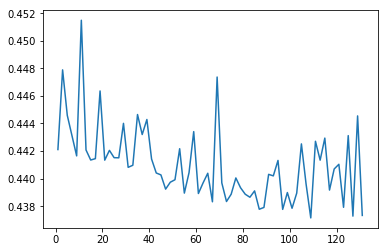

In [130]:
ranks = 0
print(training_results_sorted[ranks][0])

# training_results_sorted[ranks][1]
training_results_sorted[ranks][1].BCE.plot()